In [1]:
# !pip install einops torch maze-dataset --q

In [1]:
import os
import re
import numpy as np
import torch
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from PIL import Image
from maze_dataset.plotting import MazePlot

In [2]:
os.chdir("../")
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/I749793/Desktop/NUS/Uncertainty Modeling in AI/project/diffusion-based-environment-generator


## Loading the Dataset

In [4]:
from generator.maze.grid_world_generator import generate_multiple_grid_worlds
from generator.maze.solvers.a_star_l1 import main as a_star_l1_paths
from generator.maze.solvers.bfs import main as bfs_paths

parent_directory = "./data"
if not os.path.exists(parent_directory):
    os.makedirs(parent_directory)
# generates the mazes
mazes = generate_multiple_grid_worlds(num_worlds=1000, parent_directory=parent_directory)
# generate path travrsals
a_star_l1_paths(parent_directory)
bfs_paths(parent_directory)


Processing Mazes: 100%|██████████| 1000/1000 [00:00<00:00, 1526.74maze/s]


In [5]:
def preprocess_image(image, target_size=32):
    image = np.array(image)
    scale_factor = target_size // image.shape[0] 
    # image = np.kron(image, np.ones((scale_factor, scale_factor, 1))) 
    
    # image = image.astype(np.float32) / 127.5 - 1
    image = image.astype(np.float32)
    image = torch.tensor(image).permute(2, 0, 1)
    image = F.interpolate(image.unsqueeze(0), size=(target_size, target_size), mode='nearest').squeeze(0)  # (3, 32, 32)

    return image

def plot_grid_world(grid):
    """
    Plots the given grid world.
    """
    wall = grid[:,:,0] == 0
    source = grid[:,:,1] == 1
    destination = grid[:,:,2] == 1

    img = np.ones((*wall.shape, 3), dtype=np.float32)  # White background
    img[wall] = np.array([0, 0, 0])  # Walls → Black
    img[source] = np.array([1, 0, 0])  # Source → Red
    img[destination] = np.array([0, 1, 0])  # Destination → Green

    return img

def load_dataset_from_npy(parent_directory="./data", target_size=32):
    images = []
    path_lengths = []
    num_nodes_traversed_astar = []
    num_nodes_traversed_bfs = []
    
    mazes_directory = os.path.join(parent_directory, "mazes")
    files = sorted([f for f in os.listdir(mazes_directory) if f.endswith(".npy")])
    
    for file in files:
        img = np.load(os.path.join(mazes_directory, file))
        if(img.shape != (10,10,3)):
            continue
        # mask = np.all(img == [0, 0, 255], axis=-1)
        # img[mask] = [255, 255, 255]
        # img = img[:-1, :-1]
        # image = preprocess_image(img, target_size)

        image = plot_grid_world(img)
        mask = np.all(image == [0, 0, 255], axis=-1)
        image[mask] = [255, 255, 255]
        image = preprocess_image(image, target_size)

        pattern = r'maze_(\d+)'
        match = re.search(pattern, file)
        num = 0
        if match:
            num = int(match.group(1))
        else:
            continue
        
        # base_name = os.path.splitext(file)[0]
        # len_filename = base_name + "_len.txt"
        len_filename = f"path_length_{num}" + ".npy"
        len_path = os.path.join(mazes_directory, len_filename)
        astar_traversal_filename = f"a_star_{num}" + ".npy"
        astar_traversal_path = os.path.join(parent_directory, "a_star_l1_results" ,astar_traversal_filename)
        bfs_traversal_filename = f"bfs_{num}" + ".npy"
        bfs_traversal_path = os.path.join(parent_directory, "bfs_results" ,bfs_traversal_filename)
        
        # with open(len_path, "r") as f:
        #     maze_length = int(f.read().strip())
        maze_length = np.load(len_path)
        astar_traversal = np.load(astar_traversal_path)
        bfs_traversal = np.load(bfs_traversal_path)
        
        images.append(image)
        path_lengths.append(int(maze_length))
        num_nodes_traversed_astar.append(int(astar_traversal))
        num_nodes_traversed_bfs.append(int(bfs_traversal))
    
    return images, path_lengths, num_nodes_traversed_astar, num_nodes_traversed_bfs

# , [a / b if b!=0 else a for a, b in zip(path_lengths, num_nodes_traversed_astar)], [a / b if b!=0 else a for a, b in zip(path_lengths, num_nodes_traversed_bfs)]

In [ ]:
# img = np.load("/Users/I749793/Desktop/NUS/Uncertainty Modeling in AI/project/diffusion-based-environment-generator/data/maze_0.npy")
# img = plot_grid_world(img)
# # plt.imshow(img)
# # plt.show()

# img = preprocess_image(img, 32)
# img.shape
# # # plot_image = (img+1)*127.5 
# # plt.imshow(img.permute(1, 2, 0).cpu().numpy(), cmap='gray')
# # plt.axis('off')
# # plt.show()


In [7]:
# mazes_data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "data", "mazes")
# mazes_data_path = "./data/mazes"

mazes_data_path = "./data/"
images, org_path_lengths, num_nodes_astar, num_nodes_bfs = load_dataset_from_npy(mazes_data_path, target_size=32)

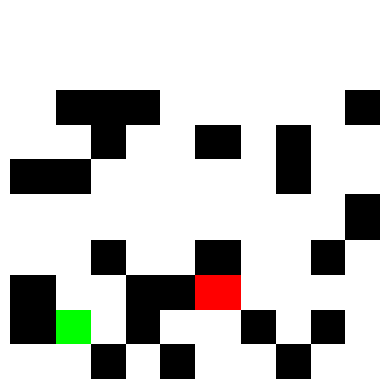

In [8]:
plt.imshow(images[0].permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

# plt.figure(figsize=(6, 6))
# plt.imshow(images[2])
# plt.axis('off')
# plt.show()


# Diffusion

In [9]:
os.chdir("./diffuser")
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/I749793/Desktop/NUS/Uncertainty Modeling in AI/project/diffusion-based-environment-generator/diffuser


### VAE Training

In [10]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from maze_dataset.plotting import MazePlot
import random

In [11]:
import importlib
import encoder
import decoder
importlib.reload(encoder)
importlib.reload(decoder)
from encoder import VAE_Encoder
from decoder import VAE_Decoder

In [12]:
# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 10
LATENT_CHANNELS = 4
# LATENT_CHANNELS = 8

In [13]:
class MazeTensorDataset(Dataset):
    def __init__(self, images, path_lengths, num_nodes_astar, num_nodes_bfs):
        self.images = images
        self.path_lengths = path_lengths
        self.num_nodes_astar = num_nodes_astar
        self.num_nodes_bfs = num_nodes_bfs
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.path_lengths[idx], self.num_nodes_astar[idx], self.num_nodes_bfs[idx]

In [14]:
path_lengths = org_path_lengths

## use the scaled path lengths based on the number of nodes traversed
# path_lengths = [a / b if b!=0 else a for a, b in zip(path_lengths, num_nodes_astar)]
# path_lengths = [a / b if b!=0 else a for a, b in zip(path_lengths, num_nodes_bfs)]

print("Total images:", len(images))
print("Total path_lengths:", len(path_lengths))

total = len(images)
test_size = int(0.2 * total)
all_indices = list(range(total))
random.shuffle(all_indices)

test_indices = all_indices[:test_size]
train_indices = all_indices[test_size:]

train_images = [images[i] for i in train_indices]
train_path_lengths = [path_lengths[i] for i in train_indices]
train_num_nodes_astar = [num_nodes_astar[i] for i in train_indices]
train_num_nodes_bfs = [num_nodes_bfs[i] for i in train_indices]

test_images = [images[i] for i in test_indices]
test_path_lengths = [path_lengths[i] for i in test_indices]
test_num_nodes_astar = [num_nodes_astar[i] for i in test_indices]
test_num_nodes_bfs = [num_nodes_bfs[i] for i in test_indices]

dataset = MazeTensorDataset(train_images, train_path_lengths, train_num_nodes_astar, train_num_nodes_bfs)
test_dataset = MazeTensorDataset(test_images, test_path_lengths, test_num_nodes_astar, test_num_nodes_bfs)

print("Train dataset length:", len(dataset))
print("Test dataset length:", len(test_dataset))

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

unique_train_paths = set(train_path_lengths)
print("Unique training path lengths:", unique_train_paths)
print("Number of unique training paths:", len(unique_train_paths))

unique_test_paths = set(test_path_lengths)
print("Unique test path lengths:", unique_test_paths)
print("Number of unique test paths:", len(unique_test_paths))

Total images: 1000
Total path_lengths: 1000
Train dataset length: 800
Test dataset length: 200
Unique training path lengths: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24}
Number of unique training paths: 22
Unique test path lengths: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 22}
Number of unique test paths: 19


Epoch [1/10], Train Loss: 1375.7907
Epoch [2/10], Train Loss: 659.4354
Epoch [3/10], Train Loss: 627.7695
Epoch [4/10], Train Loss: 606.1216
Epoch [5/10], Train Loss: 583.6786
Epoch [6/10], Train Loss: 564.7002
Epoch [7/10], Train Loss: 536.3943
Epoch [8/10], Train Loss: 492.4592
Epoch [9/10], Train Loss: 448.5114
Epoch [10/10], Train Loss: 428.2889


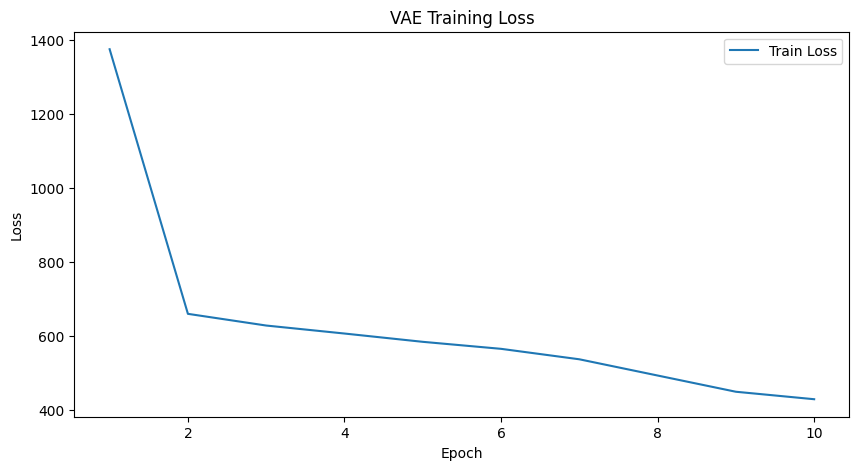

In [14]:
# Model Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = VAE_Encoder().to(device)
decoder = VAE_Decoder().to(device)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=LEARNING_RATE)

def vae_loss(x, x_hat, mean, log_var):
    # print(x.shape)
    # print(x_hat.shape)
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction='sum') / x.size(0)
    
    kl_loss = 0.5 * (mean.pow(2) + log_var.exp() - log_var - 1).sum(dim=(1, 2, 3)).mean()
    
    return recon_loss + kl_loss

train_losses = []
for epoch in range(EPOCHS):
    encoder.train()
    decoder.train()
    train_loss = 0.0
    
    for batch_idx, x in enumerate(dataloader):
        
        x = x[0].to(device)
        batch_size = x.size(0)
        
        noise = torch.randn(batch_size, LATENT_CHANNELS, 8, 8).to(device)
        # noise = torch.randn(batch_size, LATENT_CHANNELS, 6, 6).to(device)
        # noise = torch.randn(batch_size, LATENT_CHANNELS, 2, 2).to(device)
        # x = x.permute(0, 3, 1, 2) # (B, H, W, C) -> (B, C, H, W)
        mean, log_var, z = encoder(x, noise)
        x_hat = decoder(z)
        
        loss = vae_loss(x, x_hat, mean, log_var)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_size
        
    train_loss = train_loss / len(dataloader.dataset)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.legend()
plt.show()

### VAE Testing

In [15]:
test_dataset[0][0].shape

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08465234..1.2161748].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17430282..1.1858572].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00023460388..1.0301803].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32688075..1.3352588].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00014483929..1.0175037].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.33552745..1.1767582].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range 

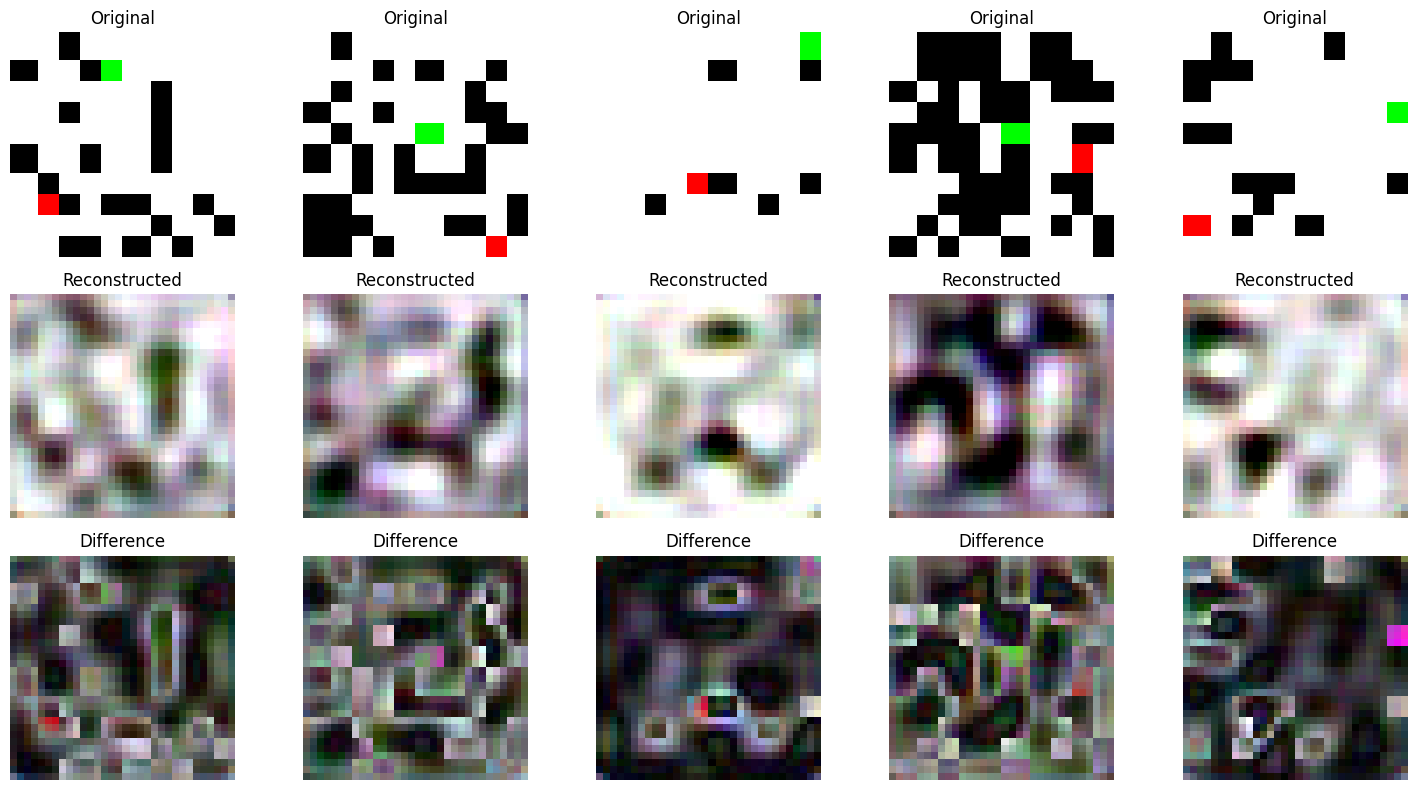

In [17]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    fig, axes = plt.subplots(3, 5, figsize=(15, 8))
    for i in range(5):
        idx = np.random.randint(len(test_dataset))
        img, _, _, _ = test_dataset[idx]  # Ignore the path length label for reconstruction
        img = img.unsqueeze(0).to(device)
        noise = torch.randn(1, LATENT_CHANNELS, 8, 8).to(device)
        # noise = torch.randn(1, LATENT_CHANNELS, 2, 2).to(device)
        # img = torch.tensor(img, dtype=torch.float32).to(device) 
        # img = img.permute(2, 0, 1).unsqueeze(0)
        _, _, z = encoder(img, noise)
        reconstructed = decoder(z).cpu().squeeze(0)
        
        original = img.cpu().squeeze(0)
        
        difference = torch.abs(original - reconstructed)
        
        axes[0, i].imshow(original.permute(1, 2, 0).numpy(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')
        
        axes[1, i].imshow(reconstructed.permute(1, 2, 0).numpy(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed')
        
        axes[2, i].imshow(difference.permute(1, 2, 0).numpy(), cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title('Difference')
    
    plt.tight_layout()
    plt.show()

In [18]:
!ls

__pycache__                  experiments.ipynb
attention.py                 experiments_multi_feat.ipynb
ddpm.py                      model.py
decoder.py                   pipeline.py
encoder.py


In [19]:
# Save Model Weights
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, '../data/vae_models/vae_weights_2.pth')

print("Model weights saved to vae_weights_2.pth")

Model weights saved to vae_weights_2.pth


## UNET

### UNET Training

In [ ]:
# Hyperparameters
BATCH_SIZE = 128
EPOCHS = 1
NUM_TIMESTEPS = 1000
LATENT_CHANNELS = 4

In [16]:
print("Total images:", len(images))
print("Total path_lengths:", len(path_lengths))

total = len(images)
test_size = int(0.2 * total)
all_indices = list(range(total))
random.shuffle(all_indices)

test_indices = all_indices[:test_size]
train_indices = all_indices[test_size:]

train_images = [images[i] for i in train_indices]
train_path_lengths = [path_lengths[i] for i in train_indices]
train_num_nodes_astar = [num_nodes_astar[i] for i in train_indices]
train_num_nodes_bfs = [num_nodes_bfs[i] for i in train_indices]

test_images = [images[i] for i in test_indices]
test_path_lengths = [path_lengths[i] for i in test_indices]
test_num_nodes_astar = [num_nodes_astar[i] for i in test_indices]
test_num_nodes_bfs = [num_nodes_bfs[i] for i in test_indices]

dataset = MazeTensorDataset(train_images, train_path_lengths, train_num_nodes_astar, train_num_nodes_bfs)
test_dataset = MazeTensorDataset(test_images, test_path_lengths, test_num_nodes_astar, test_num_nodes_bfs)

print("Train dataset length:", len(dataset))
print("Test dataset length:", len(test_dataset))

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

unique_train_paths = set(train_path_lengths)
print("Unique training path lengths:", unique_train_paths)
print("Number of unique training paths:", len(unique_train_paths))

unique_test_paths = set(test_path_lengths)
print("Unique test path lengths:", unique_test_paths)
print("Number of unique test paths:", len(unique_test_paths))

Total images: 1000
Total path_lengths: 1000
Train dataset length: 800
Test dataset length: 200
Unique training path lengths: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24}
Number of unique training paths: 22
Unique test path lengths: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20}
Number of unique test paths: 19


In [17]:
import importlib
import encoder
import decoder
import model
importlib.reload(encoder)
importlib.reload(decoder)
importlib.reload(model)
from encoder import VAE_Encoder
from decoder import VAE_Decoder
from model import Diffusion
from ddpm import DDPMSampler
# from classifier_guidance.models import Classifier

device = "cuda" if torch.cuda.is_available() else "cpu"

vae_encoder = VAE_Encoder().to(device).eval()
decoder = VAE_Decoder().to(device).eval()

checkpoint = torch.load('../data/vae_models/vae_weights_2.pth', map_location=device)
vae_encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

diffusion_model = Diffusion(input_size=2).to(device)
optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = DDPMSampler(generator=torch.Generator(device=device), num_training_steps=NUM_TIMESTEPS)

In [18]:
# bs_embed, seq_len, _ = classifier_guidance_embeddings.shape
# prompt_embeds = classifier_guidance_embeddings.repeat(1, 1, 1)
# prompt_embeds = prompt_embeds.view(bs_embed * 1, seq_len, -1)
# prompt_embeds.shape

Training epoch [1/1]:   0%|          | 0/7 [00:00<?, ?it/s]/var/folders/l5/3mpb98_x2d35xc7pmyh3tppw0000gn/T/ipykernel_41574/442902882.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  path_lengths = torch.tensor(path_lengths).float().to(device)
Training epoch [1/1]: 100%|██████████| 7/7 [05:13<00:00, 44.79s/it]

Epoch [1/1], Loss: 1.0829


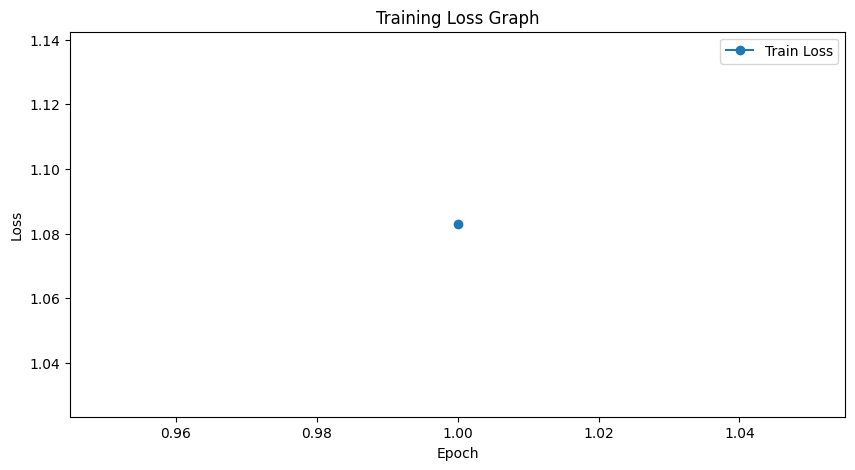

In [19]:
train_losses = []
GUIDANCE_SCALE = 7.5

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    count = 0
    for batch_idx, (images, path_lengths, nodes_astar, nodes_bfs) in enumerate(tqdm(dataloader, desc=f"Training epoch [{epoch+1}/{EPOCHS}]")):
        images = images.to(device)
        path_lengths = torch.tensor(path_lengths).float().to(device)
        zeros_path_tensor = torch.zeros_like(path_lengths).to(device)
        zeros_nodes_astar_tensor = torch.zeros_like(nodes_astar).to(device)
        
        noise = torch.randn(images.size(0), LATENT_CHANNELS, 8, 8, device=device)
        
        with torch.no_grad():
            _, _, z = vae_encoder(images, noise)
        
        timesteps = torch.randint(0, NUM_TIMESTEPS, (z.size(0),), device=device)
        
        noisy_z, noise_used = scheduler.add_noise(z, timesteps)
        # to accomodate for classifier free guidance.
        noisy_z = noisy_z.repeat(2, 1, 1, 1)
        timesteps = timesteps.repeat_interleave(2)
        
        # this is the context embedding that the model should move towards
        combined_features = torch.stack((path_lengths, nodes_astar), dim=-1)
        context = diffusion_model.condition_multidimensional_embedding(combined_features)

        # something like the a negative prompt.
        combined_zeroes_features = torch.stack((zeros_path_tensor, zeros_nodes_astar_tensor), dim=-1)
        unconditional_guidance_embeddings = diffusion_model.condition_multidimensional_embedding(combined_zeroes_features)
        conditional_guidance_embeddings = torch.cat([unconditional_guidance_embeddings, context])
        

        # noise_pred = diffusion_model(noisy_z, context, timesteps)
        noise_pred = diffusion_model(noisy_z, conditional_guidance_embeddings, timesteps)
        noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)

        noise_pred = noise_pred_uncond + GUIDANCE_SCALE * (noise_pred_cond - noise_pred_uncond)
        
        # loss = F.mse_loss(noise_pred, noise_used)
        loss = F.smooth_l1_loss(noise_pred, noise_used)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * images.size(0)
        count += images.size(0)
    
    avg_loss = epoch_loss / count if count > 0 else 0.0
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Graph')
plt.legend()
plt.show()

In [20]:
torch.save({
    'diffusion_state_dict': diffusion_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses
}, '../data/diffusion_models/diffusion_weights.pth')
print("Diffusion weights saved to diffusion_weights.pth")

Diffusion weights saved to diffusion_weights.pth


### UNET TESTING

In [25]:
def generate_maze_from_test(sample_idx=None, num_steps=50):
    diffusion_model.eval()
    scheduler.set_inference_timesteps(num_steps)
    
    if sample_idx is None:
        sample_idx = random.randint(0, len(test_dataset) - 1)
    
    test_img, test_path_length, nodes_astar, nodes_bfs = test_dataset[sample_idx]
    path_tensor = torch.tensor([test_path_length]).float().to(device)
    nodes_astar_tensor = torch.tensor([nodes_astar]).float().to(device)
    combined_features = torch.stack((path_tensor, nodes_astar_tensor), dim=-1)
    # context = diffusion_model.condition_multidimensional_embedding(
    #     torch.tensor([test_path_length], device=device).float()
    # )

    context = diffusion_model.condition_multidimensional_embedding(combined_features)
    
    latent = torch.randn((1, 4, 8, 8), device=device)
    
    for t in scheduler.timesteps:
        timestep = torch.tensor([t], device=device)
        with torch.no_grad():
            pred = diffusion_model(latent, context, timestep)
        latent = scheduler.step(t, latent, pred)
    
    with torch.no_grad():
        generated_image = decoder(latent / 0.18215)
    
    return generated_image, test_img, test_path_length

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6182678..2.1200335].


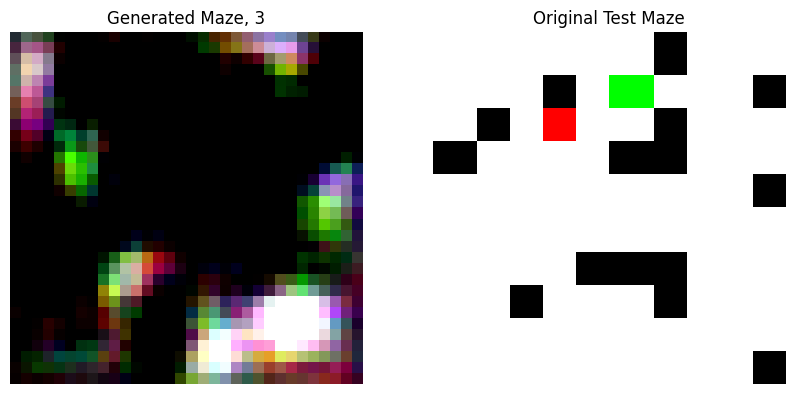

In [26]:
generated, original, test_path_length = generate_maze_from_test(num_steps=100)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(generated.squeeze(0).permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title(f"Generated Maze, {test_path_length}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(original.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title("Original Test Maze")
plt.axis("off")
plt.show()